In [1]:
import numpy as np
import pandas as pd
import glob
import xarray as xr
import matplotlib.pyplot as plt
from scipy import stats

import sys; sys.path.insert(1, '/home/alessandro/thesis_material')
import os

import geometry as gm
#import conversion as cnv
from func_statistics import compute_pdf_nbin, slopes_r_p, slopes_r_p_onlysub, slopes_r_p_mix, slope_time, slope_maps
import regression
#from coare_functions import *
import meteo
import lcl
import metpy.calc as mpcalc
from metpy.units import units


import cartopy.crs as ccrs
crs = ccrs.PlateCarree()
#from plotmap import plot_background
from plotdistr import * #fb_distribution_npoint, perc_distribution, scatterplot_fit, hist2d
from pdist_fb_distrib_save_fast import *

import warnings; warnings.filterwarnings("ignore")

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# find data
path = '/saturn/simu_Caribbean/coupled_2km/output/'
files_ls = ['QCLOUD', 'U', 'V', 'W', 'OLR', 'PH', 'PHB', 'QVAPOR', 'PB', 'P', 'T']
files_ls = [name + '.nc' for name in files_ls]
wrf_files = [path+name for name in files_ls]
#fname_list = sorted(glob.glob(wrf_files + '*'))

In [4]:
# import sea_mask
if os.path.exists('/home/alessandro/thesis_material/EURECA_scripts/masks/sea_mask_EU_new.npy'):
    sea_mask = np.load('/home/alessandro/thesis_material/EURECA_scripts/masks/sea_mask_EU_new.npy')
    
if os.path.exists('/home/alessandro/thesis_material/EURECA_scripts/masks/sea_mask_EU_noWarmPatch_noWest.npy'):
    sea_mask_modified = np.load('/home/alessandro/thesis_material/EURECA_scripts/masks/sea_mask_EU_noWarmPatch_noWest.npy')
    sea_mask_modified_nan = np.ones_like(sea_mask_modified)
    sea_mask_modified_nan[sea_mask_modified==0] = np.nan

    
    
tourbillons_mask = np.load('/home/alessandro/thesis_material/EURECA_scripts/masks/tourbillons_mask.npy')
open_ocean_mask = np.load('/home/alessandro/thesis_material/EURECA_scripts/masks/open_ocean_mask.npy')

In [5]:
### saving all my profiles to disk

## Theta and temperature

In [6]:
theta = xr.open_dataset(wrf_files[files_ls.index('T.nc')])
theta = theta['T']
theta = theta.sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-02-29T22:30:00.000000000'))
theta = theta.where(tourbillons_mask, drop=False)
theta = theta.transpose('lev_M', 'time_counter', 'y_grid_M', 'x_grid_M' )

# theta_day = theta.groupby('time_counter.day').mean()

T0 = 300. 

theta = theta+T0 #;  theta_day = theta_day+T0

In [7]:
theta_profile = np.nanmean(theta.values, axis=(1,2,3))
theta_std = np.std(theta.values, axis=(1,2,3))


In [8]:
theta_profile = xr.DataArray(theta_profile, name='theta_profile', dims=['lev_M'])
theta_profile.attrs['long name'] = 'vertical mean profile of potential temperature [K]'

theta_std = xr.DataArray(theta_std, name='theta_std', dims=['lev_M'])
theta_std.attrs['long name'] = 'vertical mean profile of stddev potential temperature [K]'


ds_theta = xr.Dataset({'theta_profile':theta_profile, 'theta_std':theta_std})
ds_theta.to_netcdf('/venus/tesi_ale/data_EU/profiles_sim/theta_prof_TOURB.nc')

In [9]:
pres_base = xr.open_dataset(wrf_files[files_ls.index('PB.nc')])
pres_base = pres_base['PB']

pres = xr.open_dataset(wrf_files[files_ls.index('P.nc')])
pres = pres['P'].sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-02-29T22:30:00.000000000'))


pres = (pres+pres_base)/100.                # hectoPascals
pres = pres.where(tourbillons_mask, drop=False)

pres = pres.transpose('lev_M', 'time_counter', 'y_grid_M', 'x_grid_M' )

del pres_base
#pres_base = pres_base.where(sea_mask, drop=False)


In [10]:
# compute actual temperature
# I DID NOT APPLY DAILY MEAN TO PRES!
temperature = theta * ( pres / 1000. )**0.286
temperature = temperature.where(tourbillons_mask, drop=False)
del theta, pres

In [11]:
temperature_profile = np.nanmean(temperature.values, axis=(1,2,3))
temperature_std = np.std(temperature.values, axis=(1,2,3))


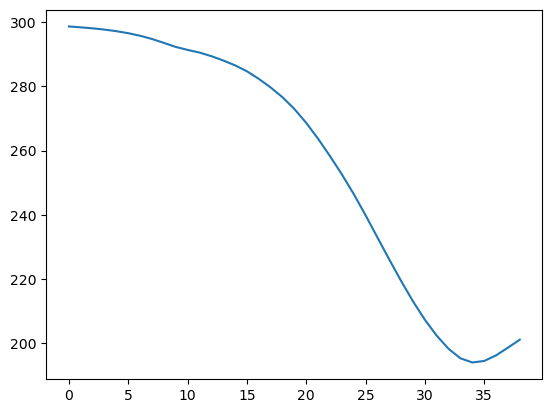

In [14]:
plt.plot(temperature_profile)

In [12]:
temperature_profile = xr.DataArray(temperature_profile, name='temperature_profile', dims=['lev_M'])
temperature_profile.attrs['long name'] = 'vertical mean profile of temperatureerature [K]'

temperature_std = xr.DataArray(temperature_std, name='temperature_std', dims=['lev_M'])
temperature_std.attrs['long name'] = 'vertical mean profile of stddev temperatureerature [K]'


ds_temperature = xr.Dataset({'temperature_profile':temperature_profile, 'temperature_std':temperature_std})
ds_temperature.to_netcdf('/venus/tesi_ale/data_EU/profiles_sim/temperature_prof_TOURB.nc')

In [13]:
qvap = xr.open_dataset(wrf_files[files_ls.index('QVAPOR.nc')])
qvap = qvap['QVAPOR'].sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-02-29T22:30:00.000000000'))
qvap = qvap.where(tourbillons_mask, drop=False)
qvap = qvap.transpose('lev_M', 'time_counter', 'y_grid_M', 'x_grid_M' )


In [14]:
qvap_std = np.nanstd(qvap.values, axis=(1,2,3))
qvap_profile = np.nanmean(qvap.values, axis=(1,2,3))

In [15]:
qvap_profile = xr.DataArray(qvap_profile, name='qvap_profile', dims=['lev_M'])
qvap_profile.attrs['long name'] = 'vertical mean profile of potential temperature [K]'

qvap_std = xr.DataArray(qvap_std, name='qvap_std', dims=['lev_M'])
qvap_std.attrs['long name'] = 'vertical mean profile of stddev potential temperature [K]'


ds_qvap = xr.Dataset({'qvap_profile':qvap_profile, 'qvap_std':qvap_std})
ds_qvap.to_netcdf('/venus/tesi_ale/data_EU/profiles_sim/qvap_prof_TOURB.nc')

In [5]:
# load U component
U = xr.open_dataset(wrf_files[files_ls.index('U.nc')])
U = U['U'].sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-02-29T22:30:00.000000000'))

i = np.arange(0, sea_mask.shape[1])
U = 0.5*(U[:,:,:,i] + U[:,:,:,i+1])

In [6]:
# load U component
V = xr.open_dataset(wrf_files[files_ls.index('V.nc')])
V = V['V'].sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-02-29T22:30:00.000000000'))

j = np.arange(0, sea_mask.shape[0])
V = 0.5*(V[:,:,j,:] + V[:,:,j+1,:])

In [7]:
U = U.transpose('lev_M', 'time_counter', 'y_grid_U', 'x_grid_U' )
V = V.transpose('lev_M', 'time_counter', 'y_grid_V', 'x_grid_V' )

U = U.where(tourbillons_mask, drop=False)
V = V.where(tourbillons_mask, drop=False)

In [8]:
wind_sp = np.sqrt((U.values**2)+(V.values**2))

In [9]:
wind_std = np.nanstd(wind_sp, axis=(1,2,3))
wind_profile = np.nanmean(wind_sp, axis=(1,2,3))

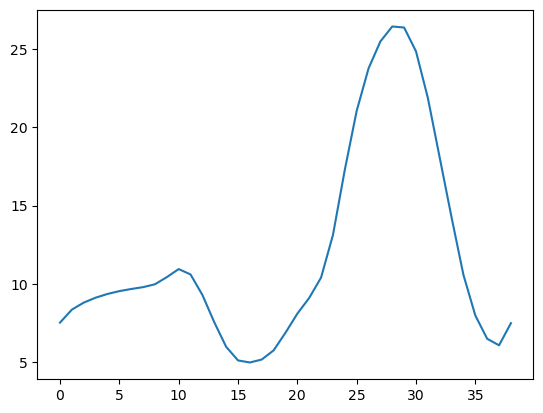

In [10]:
plt.plot(wind_profile)

In [11]:
wind_profile = xr.DataArray(wind_profile, name='wind_profile', dims=['lev_M'])
wind_profile.attrs['long name'] = 'vertical mean profile of potential temperature [K]'

wind_std = xr.DataArray(wind_std, name='wind_std', dims=['lev_M'])
wind_std.attrs['long name'] = 'vertical mean profile of stddev potential temperature [K]'


ds_wind = xr.Dataset({'wind_profile':wind_profile, 'wind_std':wind_std})
ds_wind.to_netcdf('/venus/tesi_ale/data_EU/profiles_sim/wind_prof_TOURB.nc')

# Open MS Merian radiosoundings

In [12]:
ds_rsEU = xr.open_dataset('/dagobah/RS_EUREC4A/EUREC4A_MS-Merian_Vaisala-RS_L2_v3.0.0.nc')

In [19]:
ds_rsEU

<xarray.Dataset>
Dimensions:      (alt: 3100, sounding: 156, nv: 2)
Coordinates:
  * alt          (alt) int16 0 10 20 30 40 50 ... 30950 30960 30970 30980 30990
    flight_time  (sounding, alt) datetime64[ns] ...
    lat          (sounding, alt) float32 ...
    lon          (sounding, alt) float32 ...
    launch_time  (sounding) datetime64[ns] 2020-01-18T18:35:17.717045 ... 202...
  * sounding     (sounding) object 'MS-Merian__ascent__13.55_-58.55__20200118...
Dimensions without coordinates: nv
Data variables: (12/19)
    p            (sounding, alt) float32 nan nan nan nan nan ... nan nan nan nan
    dz           (sounding, alt) float32 ...
    ta           (sounding, alt) float32 ...
    dp           (sounding, alt) float32 ...
    wspd         (sounding, alt) float32 ...
    u            (sounding, alt) float32 ...
    ...           ...
    rh           (sounding, alt) float32 ...
    N_ptu        (sounding, alt) float32 ...
    N_gps        (sounding, alt) float32 ...
    m_ptu        (sounding, alt) int16 ...
    m_gps        (sounding, alt) int16 ...
    ascent_flag  (sounding) int16 1 1 1 1 0 1 0 1 0 1 0 ... 1 0 1 0 1 1 0 1 1 0
Attributes: (12/13)
    title:            EUREC4A level 2 sounding data
    platform:         MS-Merian
    instrument:       Radiosonde RS41-SGP by Vaisala
    doi:              10.25326/137
    created_with:     batch_interpolate_soundings.py with its last modificati...
    created_on:       Tue Dec 22 18:04:23 2020
    ...               ...
    Conventions:      CF-1.7
    campaign_id:      EUREC4A
    references:       Stephan et al. (2020): Ship- and island-based atmospher...
    acknowledgement:  The MPI-M is listed as the institute of first contact. ...
    instrument_id:    Vaisala-RS
    version:          v3.0.0

In [13]:
press_EU = ds_rsEU['p'].mean(dim='sounding')/100.

theta_EU = ds_rsEU['theta'].mean(dim='sounding')
temp_EU = ds_rsEU['ta'].mean(dim='sounding')
qvap_EU = ds_rsEU['mr'].mean(dim='sounding')
wind_EU = ds_rsEU['wspd'].mean(dim='sounding')

In [14]:
thetaSTD_EU = ds_rsEU['theta'].std(dim='sounding')
tempSTD_EU = ds_rsEU['ta'].std(dim='sounding')
qvapSTD_EU = ds_rsEU['mr'].std(dim='sounding')
windSTD_EU = ds_rsEU['wspd'].std(dim='sounding')

## load simulation profiles

In [15]:
### LOAD PRESSURE COLUMN
mean_vert_pres = np.load('/venus/tesi_ale/data_EU/PRES/daily/FEB/mean_vert_pres.npy')

In [16]:
ds_qvap = xr.open_dataset('/venus/tesi_ale/data_EU/profiles_sim/qvap_prof_TOURB.nc')
qvap_prof = ds_qvap['qvap_profile'].values

ds_theta = xr.open_dataset('/venus/tesi_ale/data_EU/profiles_sim/theta_prof_TOURB.nc')
theta_prof = ds_theta['theta_profile'].values

ds_temp = xr.open_dataset('/venus/tesi_ale/data_EU/profiles_sim/temperature_prof_TOURB.nc')
temp_prof = ds_temp['temperature_profile'].values

ds_wind = xr.open_dataset('/venus/tesi_ale/data_EU/profiles_sim/wind_prof_TOURB.nc')
wind_prof = ds_wind['wind_profile'].values

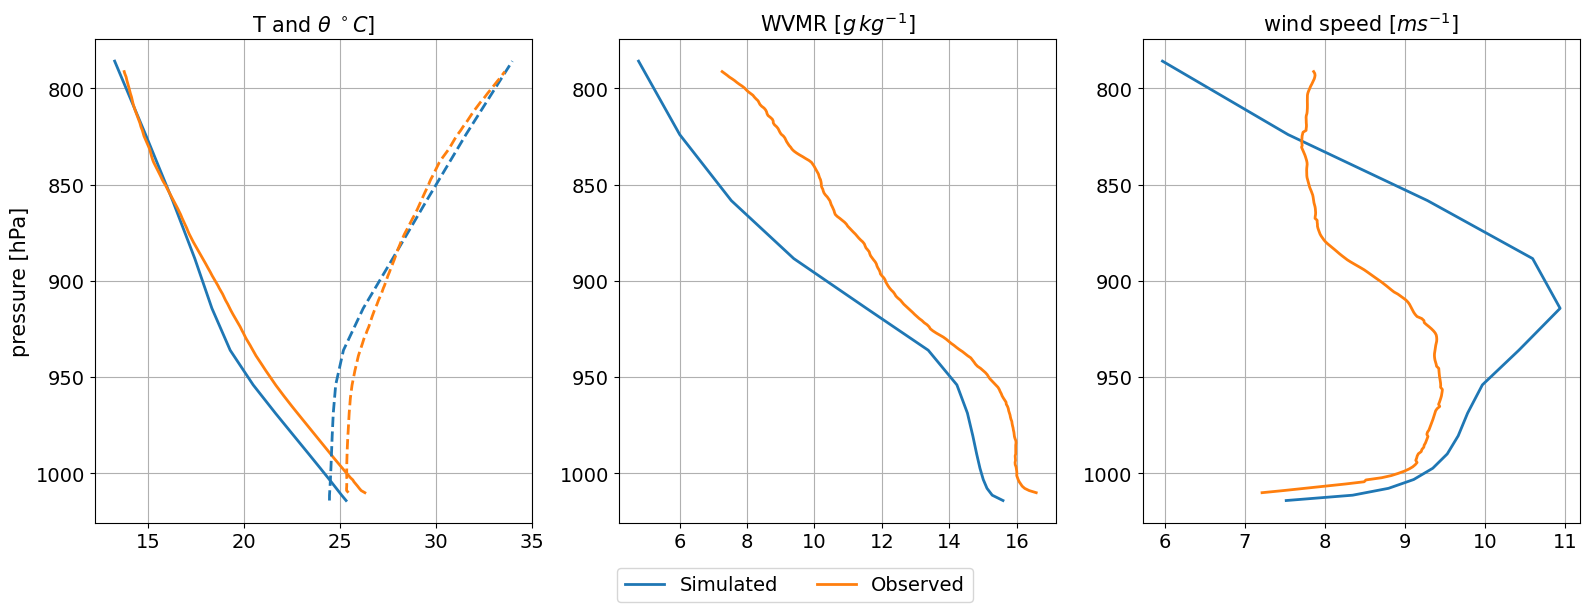

In [17]:
day = int(10)

fig, axs = plt.subplots(1, 3, figsize=(16, 6.5))
width = 2

#### temp
axs[0].invert_yaxis()

# Plotting temperature and potential temperature profiles
sim = axs[0].plot(temp_prof[0:15] - 273.15, mean_vert_pres[0:15], 'C0', label='Simulated', linewidth=width)
obs = axs[0].plot(temp_EU[0:215] - 273.15, press_EU[0:215], 'C1', label='Observed', linewidth=width)

axs[0].plot(theta_prof[0:15] - 273.15, mean_vert_pres[0:15], '--', linewidth=width)
axs[0].plot(theta_EU[0:215] - 273.15, press_EU[0:215], '--', linewidth=width)

axs[0].set_title(r"T and $\theta$ $^\circ C$]", fontsize=15)
axs[0].set_ylabel('pressure [hPa]', fontsize=15)
axs[0].grid(True)  # Adding grid

# qvap (Water Vapor Mixing Ratio)
axs[1].invert_yaxis()

axs[1].plot(qvap_prof[0:15] * 1000., mean_vert_pres[0:15], linewidth=width)
axs[1].plot(qvap_EU[0:215] * 1000., press_EU[0:215], linewidth=width)

axs[1].set_title(r"WVMR [$g\,kg^{-1}$]", fontsize=15)
axs[1].grid(True)  # Adding grid

# Wind speed
axs[2].invert_yaxis()

axs[2].plot(wind_prof[0:15], mean_vert_pres[0:15], linewidth=width)
axs[2].plot(wind_EU[0:215], press_EU[0:215], linewidth=width)

axs[2].set_title(r"wind speed [$ms^{-1}$]", fontsize=15)
axs[2].grid(True)  # Adding grid

# Adjusting ticks font size for all subplots
for ax in axs:
    ax.tick_params(axis='both', which='major', labelsize=14)

# Adding a common legend for all subplots
fig.legend([sim, obs], labels=['Simulated', 'Observed'], loc='lower center', fontsize=14, ncol=2)

plt.tight_layout(rect=[0, 0.07, 1, 0.95])  


# plt.savefig('/venus/tesi_ale/img_EU/profiles_simVsObs_TOURB.png')

plt.show()


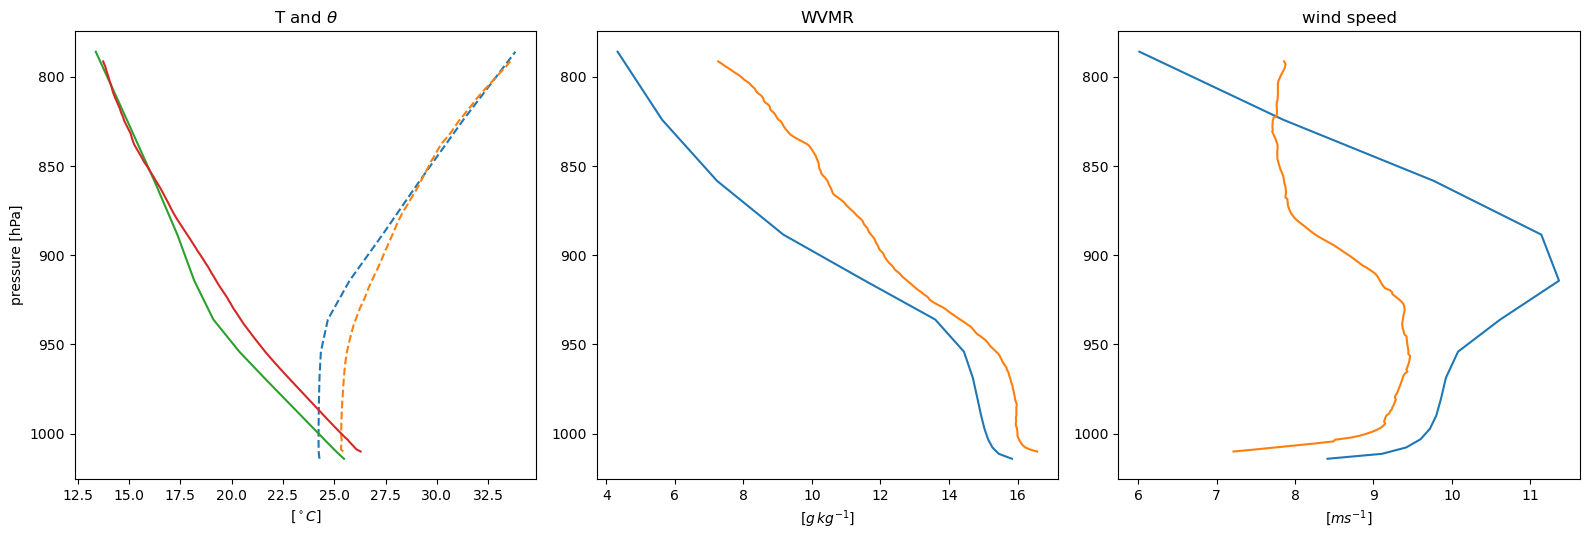

In [22]:
day = int(10)

fig, axs = plt.subplots(1,3, figsize=(16,5.5))

#### temp
axs[0].invert_yaxis()

axs[0].plot(theta_prof[0:15]-273.15, mean_vert_pres[0:15], '--' , label='Simulated')
axs[0].plot(theta_EU[0:215]-273.15, press_EU[0:215], '--' , label='Observed' )

axs[0].plot(temp_prof[0:15]-273.15, mean_vert_pres[0:15] )
axs[0].plot(temp_EU[0:215]-273.15, press_EU[0:215] )

axs[0].set_title( r"T and $\theta$")
axs[0].set_xlabel('[$^\circ C$]')
axs[0].set_ylabel('pressure [hPa]')



# qvap

axs[1].invert_yaxis()
axs[1].plot(qvap_prof[0:15]*1000., mean_vert_pres[0:15] )
axs[1].plot(qvap_EU[0:215]*1000., press_EU[0:215] )
axs[1].set_title(r"WVMR")
axs[1].set_xlabel('[$g\,kg^{-1}$]')



### wspd
axs[2].invert_yaxis()
axs[2].plot(wind_prof[0:15] , mean_vert_pres[0:15])
axs[2].plot(wind_EU[0:215] , press_EU[0:215] )

axs[2].set_title(r"wind speed")
axs[2].set_xlabel('[$ms^{-1}$]')

plt.tight_layout()